In [32]:
import config
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sb


In [33]:
#import config data
mysql = config.mysql

#connect to database
conn = psycopg2.connect(
    dbname=mysql['dbname']
    ,user=mysql['user']
    ,password=mysql['password']
    ,host=mysql['host']
    ,port=mysql['port']
    )
    

In [34]:
#list of provinces in Poland
provinces = [
    "dolnoslaskie"
    ,"kujawsko_pomorskie"
    ,"lubelskie"
    ,"lubuskie"
    ,"lodzkie"
    ,"malopolskie"
    ,"mazowieckie"
    ,"opolskie"
    ,"podkarpackie"
    ,"podlaskie"
    ,"pomorskie"
    ,"slaskie"
    ,"swietokrzyskie"
    ,"warminsko_mazurskie"
    ,"wielkopolskie"
    ,"zachodniopomorskie"
    ]

In [39]:
#dataframe to province total area renewable solar and wind
solar_area_append_total = {'Province': [], 'solar_area': [], 'wind_area_total': []}
# Import data from database
for province in provinces:
    #select tables
    table_name_solar = f"solar_radiation_photovoltaic_area_{province}"
    table_name_wind = f"wind_speed_area_{province}"
    
    #select data in tables
    query_solar = f"SELECT SUM(area) as solar_total_area FROM {table_name_solar}"
    query_wind = f"SELECT SUM(area) as wind_total_area FROM {table_name_wind}"
    #result to pandas
    solar_result = pd.read_sql(query_solar, conn)
    wind_result = pd.read_sql(query_wind, conn)
    
    #check select data 
    if not solar_result.empty and solar_result['solar_total_area'][0] is not None:
        solar_area = solar_result['solar_total_area'][0]
    else:
        solar_area = 0

    if not wind_result.empty and wind_result['wind_total_area'][0] is not None:
        wind_area = wind_result['wind_total_area'][0]
    else:
        wind_area = 0
    
    solar_area_append_total['Province'].append(province)
    solar_area_append_total['solar_area'].append(solar_area)
    solar_area_append_total['wind_area_total'].append(wind_area)

df_solar_wind = pd.DataFrame(solar_area_append_total)



C:\Users\dawid\AppData\Local\Temp\ipykernel_11148\3024949864.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  solar_result = pd.read_sql(query_solar, conn)
C:\Users\dawid\AppData\Local\Temp\ipykernel_11148\3024949864.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  wind_result = pd.read_sql(query_wind, conn)


,Province,solar_area,wind_area_total
0,dolnoslaskie,4.806358e+08,2.204043e+08
1,kujawsko_pomorskie,2.624953e+08,1.008971e+08
2,lubelskie,5.942939e+08,4.733963e+08
3,lubuskie,3.264057e+08,3.665051e+08
4,lodzkie,4.852021e+08,1.048593e+08
5,malopolskie,4.418714e+08,8.630667e+07
6,mazowieckie,1.344642e+09,5.512918e+08
7,opolskie,9.019596e+07,4.703470e+07
8,podkarpackie,5.684806e+08,1.952357e+08
9,podlaskie,9.621205e+08,7.228453e+08


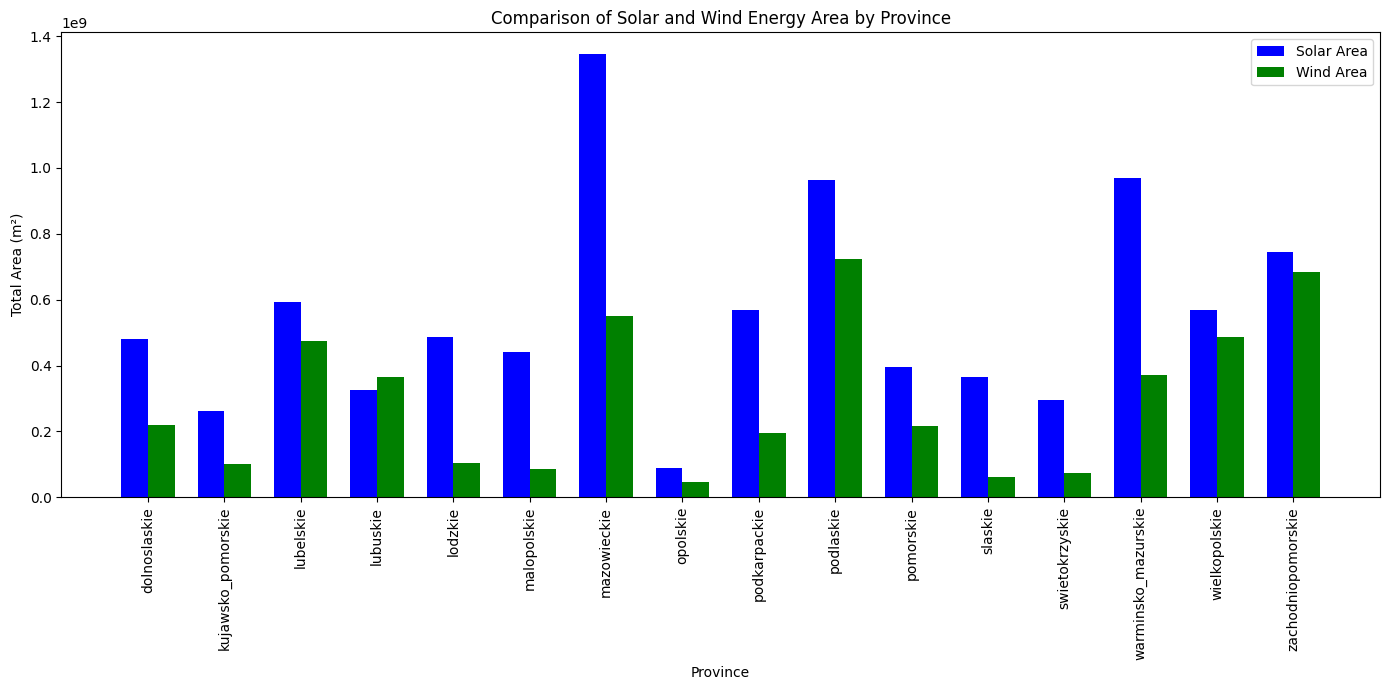

In [46]:
# Generowanie wykresu słupkowego
plt.figure(figsize=(14, 7))
width = 0.35  # szerokość słupków

# Pozycje słupków dla każdego województwa
ind = range(len(df_solar_wind['Province']))

# Tworzenie słupków dla energii słonecznej i wiatrowej
plt.bar(ind, df_solar_wind['solar_area'], width=width, label='Solar Area', color='blue')
plt.bar([i + width for i in ind], df_solar_wind['wind_area_total'], width=width, label='Wind Area', color='green')

# Dodanie opisów i tytułu
plt.xlabel('Province')
plt.ylabel('Total Area (m²)')
plt.title('Comparison of Solar and Wind Energy Area by Province')
plt.xticks([i + width / 2 for i in ind], df_solar_wind['Province'], rotation=90)
plt.legend()

# Wyświetlenie wykresu
plt.tight_layout()
plt.show()